How to make SVG without X11: http://matplotlib.org/faq/howto_faq.html#matplotlib-in-a-web-application-server

How to embed in django: make SVG, replace in template http://stackoverflow.com/questions/34958702/embedding-a-matplotlib-plot-within-a-django-site

Alternatively, make PNG and embed as base64


In [2]:
%qtconsole

In [3]:
import pickle
import matplotlib
matplotlib.use('Agg')
import pandas as pd
from IPython.display import SVG, display


In [3]:
pd=pickle.load(open("pd.pickle","rb"))


Please cite -- HTMD: High-Throughput Molecular Dynamics for Molecular Discovery
J. Chem. Theory Comput., 2016, 12 (4), pp 1845-1852. 
http://pubs.acs.org/doi/abs/10.1021/acs.jctc.6b00049



Using Anaconda API: https://api.anaconda.org


You are on the latest HTMD version (unpackaged : /home/toni/work/htmd/htmd/htmd).



In [4]:
# Alternatively
from htmd import *
pm,pd=proteinPrepare(Molecule("3PTB"),returnDetails=True)


2017-01-11 17:35:41,848 - htmd.molecule.molecule - INFO - Using local copy for 3PTB: /home/toni/work/htmd/htmd/htmd/data/pdb/3ptb.pdb
2017-01-11 17:35:42,128 - propka - INFO - No pdbfile provided
2017-01-11 17:35:44,452 - htmd.builder.preparation - WARNING - The following residue has not been optimized: CA
2017-01-11 17:35:44,453 - htmd.builder.preparation - WARNING - The following residue has not been optimized: BEN
2017-01-11 17:35:47,558 - htmd.builder.preparationdata - INFO - The following residues are in a non-standard state: CYS    22  A (CYX), HIS    40  A (HIE), CYS    42  A (CYX), HIS    57  A (HIP), CYS    58  A (CYX), HIS    91  A (HID), CYS   128  A (CYX), CYS   136  A (CYX), CYS   157  A (CYX), CYS   168  A (CYX), CYS   182  A (CYX), CYS   191  A (CYX), CYS   201  A (CYX), CYS   220  A (CYX), CYS   232  A (CYX)
2017-01-11 17:35:47,560 - htmd.builder.preparationdata - WARNING - Dubious protonation state: the pKa of 3 residues is within 1.0 units of pH 7.0.
2017-01-11 17:35:

In [22]:
def get_pka_plot(prepData, pH=7.4, figSizeX=10, dpk=1.0):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import LinearSegmentedColormap
    
    
    # Shading
    Xe = np.array([[1,0],[1,0]])
    
    # Shading colors http://matplotlib.org/examples/pylab_examples/custom_cmap.html
    neutral_grey = (.7,.7,.7)
    my_red = (.98, .41, .29)
    my_blue = (.42, .68, .84)
    grey_red = LinearSegmentedColormap.from_list("grey_red",[neutral_grey,my_red ] )
    grey_blue = LinearSegmentedColormap.from_list("grey_blue",[neutral_grey,my_blue ] )
    eps = .01 # Tiny overprint to avoid very think white lines

    
    # Color for pk values
    pkcolor = "black"
    pkfontsize = 6
    dtxt = .3       # Displacement 
    
    
    # Or we could change the figure size, which scales axes
    # http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    SIZE = 8
    plt.rc('font', family="Open Sans")
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

    
    # Constants
    acidicResidues = ['ASP','GLU','TYR']
    basicResidues = ['HIS','LYS','ARG']
    
    # titr =  (~ pd.isnull(d.pKa)) & d.pKa < 99
    d = prepData.data.copy()
    titr =  d.pKa < 99  # Automatically excludes NaN
    N = sum(titr)
    
    # Dubious residues
    d['dubious'] = abs(d.pKa - pH) < dpk
    
    # Format residue labels
    labels = ["{:s} {:s}:{:d}{:s}- {:s}".format("(!)" if x.dubious else "",
                                                x.chain,
                                                x.resid,
                                                x.insertion,
                                                x.resname) 
              for i,x in d.loc[titr].iterrows()]
    pKas = d.pKa.loc[titr]
    restypes = ["neg" if x.resname in acidicResidues else "pos" for i,x in d.loc[titr].iterrows() ]
    

    xmin, xmax = xlim = 0, 14
    ymin, ymax = ylim = -1, N
    
    width=.8    # Of each band
    
    # So, arbitrarily, 40 residues are square
    sizePerBand = figSizeX * (N/40)
    figsize=(figSizeX,sizePerBand)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, xlim=xlim, ylim=ylim,
                         autoscale_on=False)

    ax.xaxis.tick_top()
    ax.set_xlabel("pKa")
    ax.xaxis.set_label_position('top') 

    ax.yaxis.set_ticks(range(N))
    ax.yaxis.set_ticklabels(labels)
    ax.invert_yaxis()

        
    for i in range(N):
        left=xmin
        right=xmax
        top=i+width/2
        bottom=i-width/2
        pk = pKas.iloc[i]
        restype = restypes[i]
        
        if restype == "neg":
            ax.imshow(Xe*0, interpolation="none",
                      cmap=grey_blue, vmin=0, vmax=1,
                      extent=(left, pk-dpk, bottom, top), alpha=1)
            ax.imshow(np.fliplr(Xe), interpolation="bicubic",
                      cmap=grey_blue, vmin=0, vmax=1,
                      extent=(pk-dpk-eps, pk+dpk, bottom, top), alpha=1)
            ax.imshow(1+Xe*0, interpolation="none",
                      cmap=grey_blue, vmin=0, vmax=1,
                      extent=(pk+dpk-eps, right, bottom, top), alpha=1)
            ax.text(pk-dtxt,i," {:5.2f} ".format(pk),color=pkcolor, 
                    fontsize=pkfontsize, horizontalalignment="right",zorder=30)
        else:
            ax.imshow(1+Xe*0, interpolation="none",
                      cmap=grey_red, vmin=0, vmax=1,
                      extent=(left, pk-dpk, bottom, top), alpha=1)
            ax.imshow(Xe, interpolation="bicubic",
                      cmap=grey_red, vmin=0, vmax=1,
                      extent=(pk-dpk-eps, pk+dpk, bottom, top), alpha=1)
            ax.imshow(Xe*0, interpolation="none",
                      cmap=grey_red, vmin=0, vmax=1,
                      extent=(pk+dpk-eps, right, bottom, top), alpha=1)
            ax.text(pk+dtxt,i," {:5.2f} ".format(pk),color=pkcolor, 
                    fontsize=pkfontsize, horizontalalignment="left",zorder=30)
        ax.add_line(Line2D([pk,pk], [bottom,top], linewidth=3, color='white',zorder=2))

        # ax.add_line(Line2D([pk,pk], [bottom,top], linewidth=3, color='blue'))
        

    ## Shaded vertical band at pH  
    ax.axvline(x=pH-dpk, linewidth=2, color="black", alpha=.2, linestyle="dashed") 
    ax.axvline(x=pH+dpk, linewidth=2, color="black", alpha=.2, linestyle="dashed") 
    ax.axvline(x=pH, linewidth=3, color="black",alpha=.5) 
    ax.text(pH-dpk, ymax, " 90% protonated", rotation=90, 
            horizontalalignment="right", verticalalignment="bottom")
    ax.text(pH+dpk, ymax, " 10% protonated", rotation=90, 
            horizontalalignment="left", verticalalignment="bottom")
    

    ax.set_aspect('auto')
    
    # show()   # for interactive use
    from io import StringIO
    imgdata = StringIO()
    fig.savefig(imgdata, format="svg", bbox_inches='tight',)
    ret_img = imgdata.getvalue()
    
    fig.savefig("out.svg")
    fig.savefig("out.png") 
    
    # Png render may be a bit better -   
    # http://stackoverflow.com/questions/14824522/dynamically-serving-a-matplotlib-image-to-the-web-using-python
    ## 
    # from io import StringIO
    # buf = io.BytesIO()
    # plt.savefig(buf, format='png')
    # image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
    # buf.close()
    
    plt.close(fig)
    return ret_img


<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="642pt" version="1.1" viewBox="0 0 645 642" width="645pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{s ...


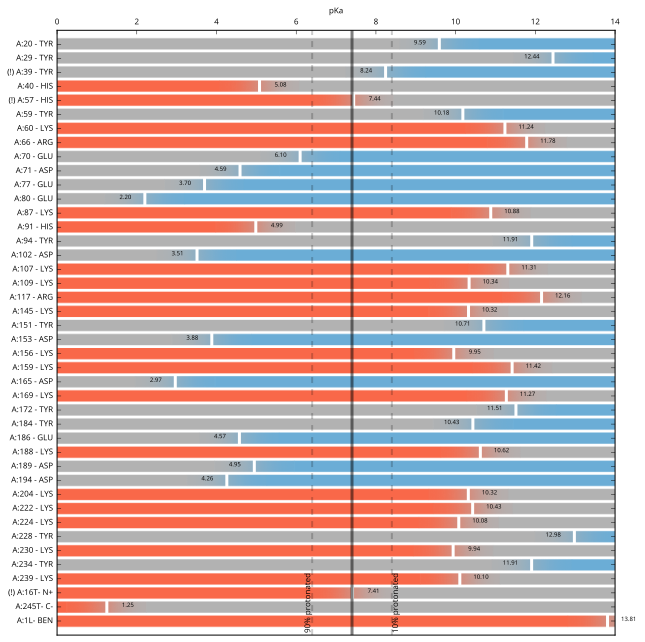

In [23]:
svg_plot=get_pka_plot(pd, pH=7.4)
print(svg_plot[0:400], "...")
display(SVG(svg_plot))